# Data-Driven Stochastic Agent-Based Metapopulation SEIIIRD Model

## Authors
* Pietro Monticone
* Davide Orsenigo

## Framework 
* Data exploration, selection and processing in Python 
* Modelling and simulations in Julia 

## Desiderata
1. Design compartmental diagram for epidemic ($\alpha_X$, $d_X$, $\beta_X(age)$,...) and surveillance systems  ($O,N,P,H/W,R$)
1. Implement timeline of policy interventions
1. Import real COVID-19 data for Italy (tests, lockdown_mobility,...)
1. Implement contact-tracing app and centrality-based passive and active surveillance strategies

## Age Categories
* Young : [1,6]
* Middle: [7,12]
* Old: [13,16]

## Age-Specific Distributions 
* Susceptibility to infection upon contact with an infectious person $\mathcal{N}(\mu=0.1,\sigma=0.023, min=0)$ 
* Symptomatic fraction on infection: 
$$y_y\sim \mathcal{N}(\mu=0.5,\sigma=0.1, min=0, max=0.5)$$
$$y_m = 0.5$$
$$y_o \sim \mathcal{N}(\mu=0.5,\sigma=0.1, min=0.5, max=1)$$

## Delays
* Incubation period ($E$ to $I_a$ and $E$ to $I_s$; days): $$d_E \sim \mathcal{\Gamma}(\mu = 3.0, k = 4)$$
* Duration of infectiousness in days during the pre-symptomatic phase $d_P=\mathcal{\Gamma}(1.5,4)$
*  Duration of infectiousness in days during the symptomatic phase $d_S=\mathcal{\Gamma}(3.5,4)$
*  Duration of infectiousness in days during the a-symptomatic phase $d_A=\mathcal{\Gamma}(5,4)$

## Diagnostic Strategies

* Passive, national, random, uniform
* Passive, national, random, uniform, contact-tracing
* Passive, national, age-stratified / ex-ante fatality risk, contact-tracing
* Passive, national, targeted, symptom-based / ex-post fatality risk
* Passive, national, targeted, symptom-based / ex-post fatality risk, contact-tracing

* Passive, provincial, random, uniform
* Passive, provincial, random, uniform, contact-tracing
* Passive, provincial, age-stratified / ex-ante fatality risk, contact-tracing
* Passive, provincial, targeted, symptom-based / ex-post fatality risk
* Passive, provincial, targeted, symptom-based / ex-post fatality risk, contact-tracing

* Active, national, random, uniform
* Active, national, random, uniform, contact-tracing
* Active, national, age-stratified / ex-ante fatality risk, contact-tracing
* Active, national, targeted, symptom-based / ex-post fatality risk
* Active, national, targeted, symptom-based / ex-post fatality risk, contact-tracing

* Active, provincial, random, uniform
* Active, provincial, random, uniform, contact-tracing
* Active, provincial, age-stratified / ex-ante fatality risk, contact-tracing
* Active, provincial, targeted, symptom-based / ex-post fatality risk
* Active, provincial, targeted, symptom-based / ex-post fatality risk, contact-tracing

* All the above with behavioral module: endogenous, individual-based physical distancing (local and global)
* All the above with behavioral module: exogeneous, enforced physical distancing (local and global lockdown)

* **Special one**: Active, provincial, targeted, symptom-based, symptomatic-is-positive, contact-tracing, endogenous & exogenous distancing: assume all symptomatic patients to be **positive** ($I_s$) without testing them (accepting the uncertainty of the symptom-based MD diagnosis) in order to allocate more diagnostic resources to the active surveillance of exposed, asymptomatic, vulnerable patients.

## Modules

In [1]:
# Data Management 
using DataFrames, DataFramesMeta, DrWatson, Queryverse
# Statistics
using StatsBase, Distributions, Random
# Graphs 
using LightGraphs, SimpleWeightedGraphs, GraphIO, GraphPlot
# Modelling
using Agents
# Numerical Computation 
using LinearAlgebra
# Visualization
using Plots, AgentsPlots, PlotThemes, Images, ImageIO

## Data

### Population

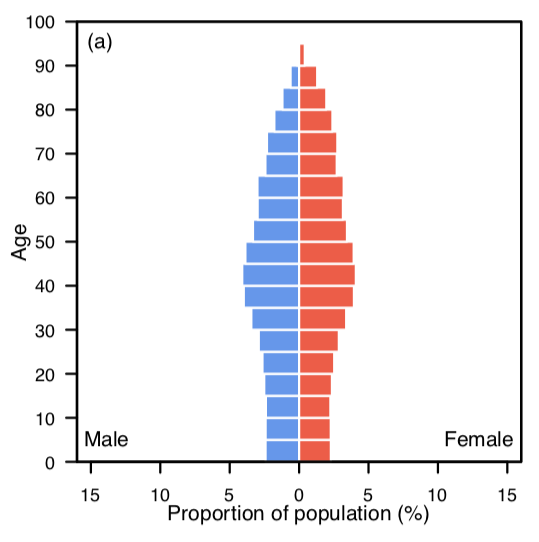

In [2]:
# Load population data
population_data = DataFrame(load("/Users/Pit/GitHub/DigitalEpidemiologyProject/Data/CSV/2020/Population/ProvincialPopulation.csv"));
# Load age-stratified population data
age_population_data = DataFrame(load("/Users/Pit/GitHub/DigitalEpidemiologyProject/Data/CSV/2020/Population/AgeStratifiedProvincialPopulation.csv"));

# Load population pyramid
population_pyramid = load("/Users/Pit/GitHub/DigitalEpidemiologyProject/Images/PopulationPyramid.png")

# ALTERNATIVE POPULATION DATA PATHS
## PIETRO1: "/Users/Pit/GitHub/DigitalEpidemiologyProject/Data/CSV/2020/Population/ProvincialPopulation.csv"
## PIETRO2: "/Users/pietromonticone/github/DigitalEpidemiologyProject/Data/CSV/2020/Population/ProvincialPopulation.csv"
## DAVIDE: raw"C:\Users\Utente\Desktop\Progetti\GitHub\DigitalEpidemiologyProject\Data\CSV\2020\Population\ProvincialPopulation.csv"

# ALTERNATIVE AGE-STRATIFIED POPULATION DATA PATHS
## PIETRO1: "/Users/Pit/GitHub/DigitalEpidemiologyProject/Data/CSV/2020/Population/AgeStratifiedProvincialPopulation.csv"
## PIETRO2: "/Users/pietromonticone/github/DigitalEpidemiologyProject/Data/CSV/2020/Population/AgeStratifiedProvincialPopulation.csv"
## DAVIDE: raw"C:\Users\Utente\Desktop\Progetti\GitHub\DigitalEpidemiologyProject\Data\CSV\2020\Population\AgeStratifiedProvincialPopulation.csv"

# ALTERNATIVE POPULATION IMAGE PATHS
## PIETRO1: "/Users/Pit/GitHub/DigitalEpidemiologyProject/Images/PopulationPyramid.png"
## PIETRO2: "/Users/pietromonticone/github/DigitalEpidemiologyProject/Images/PopulationPyramid.png"
## DAVIDE: raw"C:\Users\Utente\Desktop\Progetti\GitHub\DigitalEpidemiologyProject\Images/PopulationPyramid.png"

### Contact

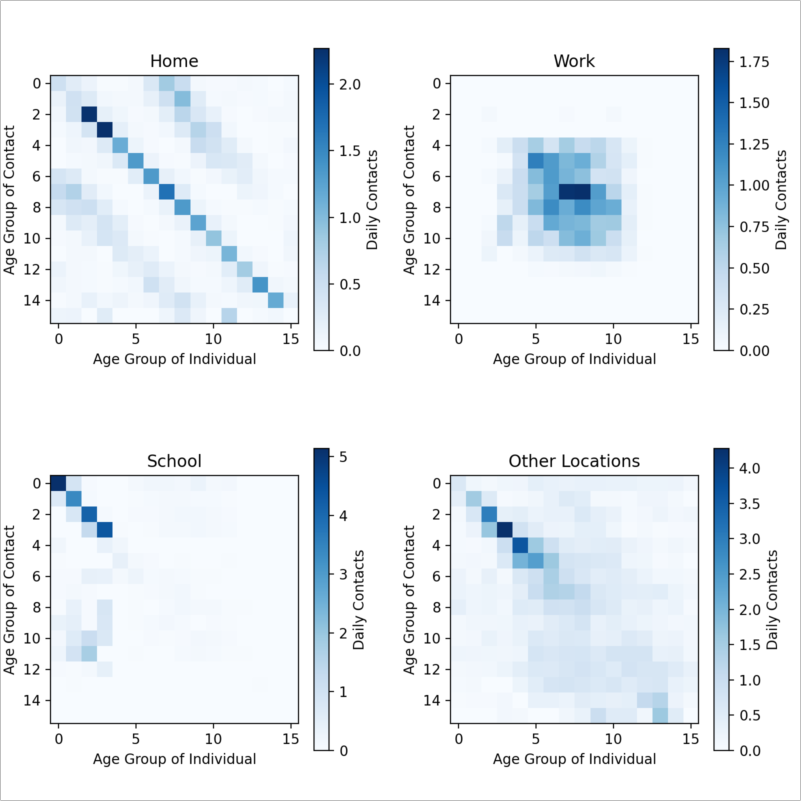

In [3]:
# Load contact data for all locations
all_contact_data = DataFrame(load("/Users/Pit/GitHub/DigitalEpidemiologyProject/Data/CSV/ContactMatrices/AllEdgeList.csv"))
# Build contact graph for all locations
all_contact_graph = SimpleWeightedDiGraph(all_contact_data[1].+1, all_contact_data[2].+1, all_contact_data[3]);
# Load contact matrix plot for all locations
all_contact_image = load("/Users/Pit/GitHub/DigitalEpidemiologyProject/Images/Contact/All.png")

# Load contact data for home
home_contact_data = DataFrame(load("/Users/Pit/GitHub/DigitalEpidemiologyProject/Data/CSV/ContactMatrices/AllEdgeList.csv"))
# Build contact graph for home
home_contact_graph = SimpleWeightedDiGraph(home_contact_data[1].+1, home_contact_data[2].+1, home_contact_data[3]);
# Load contact matrix plot for home
home_contact_image = load("/Users/Pit/GitHub/DigitalEpidemiologyProject/Images/Contact/Home.png")

# Load contact data for work
work_contact_data = DataFrame(load("/Users/Pit/GitHub/DigitalEpidemiologyProject/Data/CSV/ContactMatrices/AllEdgeList.csv"))
# Build contact graph for work
work_contact_graph = SimpleWeightedDiGraph(work_contact_data[1].+1, work_contact_data[2].+1, work_contact_data[3]);
# Load contact matrix plot for work
work_contact_image = load("/Users/Pit/GitHub/DigitalEpidemiologyProject/Images/Contact/Work.png")

# Load contact data for school
school_contact_data = DataFrame(load("/Users/Pit/GitHub/DigitalEpidemiologyProject/Data/CSV/ContactMatrices/AllEdgeList.csv"))
# Build contact graph for school
school_contact_graph = SimpleWeightedDiGraph(school_contact_data[1].+1, school_contact_data[2].+1, school_contact_data[3]);
# Load contact matrix plot for school
school_contact_image = load("/Users/Pit/GitHub/DigitalEpidemiologyProject/Images/Contact/School.png")

# Load contact data for other locations
other_contact_data = DataFrame(load("/Users/Pit/GitHub/DigitalEpidemiologyProject/Data/CSV/ContactMatrices/AllEdgeList.csv"))
# Build contact graph for other locations
other_contact_graph = SimpleWeightedDiGraph(other_contact_data[1].+1, other_contact_data[2].+1, other_contact_data[3]);
# Load contact matrix plot for other locations
other_contact_image = load("/Users/Pit/GitHub/DigitalEpidemiologyProject/Images/Contact/Other.png");

[home_contact_image work_contact_image
school_contact_image other_contact_image]

# ALTERNATIVE CONTACT DATA PATHS 

# ALTERNATIVE CONTACT IMAGE PATHS 

### Mobility

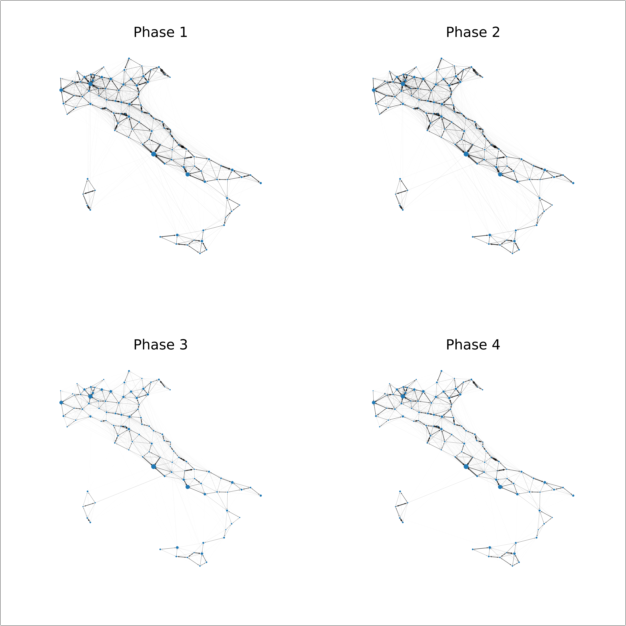

In [4]:
# Load mobility data
mobility_data_phase1 = DataFrame(load("/Users/Pit/GitHub/DigitalEpidemiologyProject/Data/CSV/2020/Mobility/Flow1.csv"))
mobility_data_phase2 = DataFrame(load("/Users/Pit/GitHub/DigitalEpidemiologyProject/Data/CSV/2020/Mobility/Flow2.csv"))
mobility_data_phase3 = DataFrame(load("/Users/Pit/GitHub/DigitalEpidemiologyProject/Data/CSV/2020/Mobility/Flow3.csv"))
mobility_data_phase4 = DataFrame(load("/Users/Pit/GitHub/DigitalEpidemiologyProject/Data/CSV/2020/Mobility/Flow4.csv"))

# Build mobility graphs 
mobility_graph_phase1 = SimpleWeightedDiGraph(mobility_data_phase1[1], mobility_data_phase1[2], mobility_data_phase1[3])
mobility_graph_phase2 = SimpleWeightedDiGraph(mobility_data_phase2[1], mobility_data_phase2[2], mobility_data_phase2[3])
mobility_graph_phase3 = SimpleWeightedDiGraph(mobility_data_phase3[1], mobility_data_phase3[2], mobility_data_phase3[3])
mobility_graph_phase4 = SimpleWeightedDiGraph(mobility_data_phase4[1], mobility_data_phase4[2], mobility_data_phase4[3])

mobility_graph = SimpleWeightedDiGraph(mobility_data_phase1[1], mobility_data_phase1[2], mobility_data_phase1[3])

# Remove the 104/5/6/7th node: provincial code doesn't exist
for i in 1:4
    rem_vertex!(mobility_graph_phase1, 104)
    rem_vertex!(mobility_graph_phase2, 104)
    rem_vertex!(mobility_graph_phase3, 104)
    rem_vertex!(mobility_graph_phase4, 104)
    rem_vertex!(mobility_graph, 104)
end

# ADD MOBILITY DATA PATHS 
### PIETRO1: "/Users/Pit/GitHub/DigitalEpidemiologyProject/Data/CSV/2020/MobilityFlow.csv"
### PIETRO2: "/Users/pietromonticone/github/DigitalEpidemiologyProject/Data/CSV/2020/MobilityFlow.csv"
### DAVIDE: raw"C:\Users\Utente\Desktop\Progetti\GitHub\DigitalEpidemiologyProject\Data\CSV\2020\MobilityFlow.csv"

mobility_phase1_image = load("/Users/Pit/GitHub/DigitalEpidemiologyProject/Images/Mobility/Phase1.png")	
mobility_phase2_image = load("/Users/Pit/GitHub/DigitalEpidemiologyProject/Images/Mobility/Phase2.png")
mobility_phase3_image = load("/Users/Pit/GitHub/DigitalEpidemiologyProject/Images/Mobility/Phase3.png")
mobility_phase4_image = load("/Users/Pit/GitHub/DigitalEpidemiologyProject/Images/Mobility/Phase4.png")

[mobility_phase1_image mobility_phase2_image
mobility_phase3_image mobility_phase4_image]

# ALTERNATIVE MOBILITY DATA PATHS 

# ALTERNATIVE MOBILITY IMAGE PATHS 

### Epidemiological

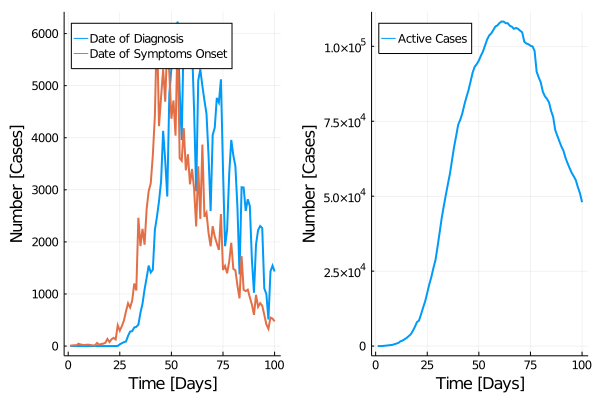

In [5]:
active_cases = DataFrame(load("/Users/Pit/GitHub/DigitalEpidemiologyProject/Data/CSV/2020/Epidemiological/Active.csv"))
symptoms_diagnosis_cases = DataFrame(load("/Users/Pit/GitHub/DigitalEpidemiologyProject/Data/CSV/2020/Epidemiological/SymptomsDiagnosis.csv"))
tests = DataFrame(load("/Users/Pit/GitHub/DigitalEpidemiologyProject/Data/CSV/2020/Epidemiological/Tests.csv"))
# ADD POPULATION DATA PATHS 
### PIETRO1: "/Users/Pit/GitHub/DigitalEpidemiologyProject/Data/CSV/2020/ActiveCases.csv"
### PIETRO2: "/Users/pietromonticone/github/DigitalEpidemiologyProject/Data/CSV/2020/ActiveCases.csv"
### DAVIDE: raw"C:\Users\Utente\Desktop\Progetti\GitHub\DigitalEpidemiologyProject\Data\CSV\2020\ActiveCases.csv"

plot_cases=plot(1:100,symptoms_diagnosis_cases["Diagnosis"][1:100],
                label="Date of Diagnosis",
                xlab="Time [Days]",
                ylabel="Number [Cases]",
                #title="COVID-19 Confirmed Cases in Italy", 
                legend=:topleft,
                lw=2)
            plot!(plot_cases,1:100,symptoms_diagnosis_cases["Symptoms"][1:100],
                 label="Date of Symptoms Onset",
                 lw=2);

plot_active=plot(1:100,active_cases["Active Cases"][1:100],
    label="Active Cases",
    xlab="Time [Days]",
    ylabel="Number [Cases]",
    #title="COVID-19 Confirmed Cases in Italy", 
    legend=:topleft,
    lw=2);
    
plot(plot_cases, plot_active, layout=2)

# ALTERNATIVE EPIDEMIOLOGICAL DATA PATHS 

# ALTERNATIVE EPIDEMIOLOGICAL IMAGE PATHS 

## Agent Type

In [6]:
# Patient Definition
mutable struct Patient <: AbstractAgent
    id::Int           # identity code ∈ ℕ               
    pos::Int          # location node ∈ ℕ 
    age_group::Int    # age group ∈ [1,16] ⊂ ℕ
    residence::Int    # residence node ∈ ℕ || RESIDENCE!!
    household::Array  # household
    workplace::Array  # workplace
    status::Symbol    # ∈ {S,E,I_a,I_p,I_s,H,ICU,R,D}
    delay_left::Int   
    diagnosis::Symbol # ∈ {N,O,P,HR} || DOUBLE NEGATIVE TEST!!!
    #prescription::Symbol # ∈ {O, Q, ICU}
    #serological
    #contact-tracing
    #fear, risk aversion -> individual-based social distancing  
end;

## Utilities

In [7]:
function TruncatedNormal(μ,σ,min,max)
    y = 0
    while true
        y = rand(Normal(μ,σ))
        if y ≥ min && y ≤ max
            break
        end	
    end
    return y
end

function SymptomaticFraction(age_group)
    if age_group ≤ 6
        return TruncatedNormal(0.5,0.1,0,0.5)
    elseif age_group ≤ 12
        return 0.5
    else
        return TruncatedNormal(0.5,0.1,0.5,1)
    end
end

function IFR(age_group) #Merler2020
    if age_group ≤ 10
        return 0 # Avg, but thing about the distribution
    elseif age_group ≤ 12
        return 0.46/100
    elseif age_group ≤ 14
        return 1.42/100
    else 
        return 6.87/100
    end
end

function DiagnosticRate(status,request)
    false_negative_rate=0
    false_positive_rate=0
    if status==:E
        false_negative_rate=(0.67+1)/2
        false_positive_rate=0.06
    elseif status==:I_s || status==:I_a
        false_negative_rate=(0.38+0.20)/2
        false_positive_rate=0.02
    elseif status==:I_p
        false_negative_rate=(0.67+0.38)/2
        false_positive_rate=0.04
    end
    if request == "false_negative_rate"
        return false_negative_rate
    else
        return false_positive_rate
    end
end
    
function InitializeHousehold(agent, model)
    neighbors = [neighbor for neighbor in get_node_agents(agent.residence, model) if neighbor != agent]
    contacted_agents = []
    for age_group in 1:K
        aged_neighbors = [neighbor for neighbor in neighbors if neighbor.age_group == age_group]  
        ncontacts = round(Int, LightGraphs.weights(model.home_contact_graph)[age_group, agent.age_group]) 
        if length(aged_neighbors)>0 && ncontacts>0
                push!(contacted_agents, StatsBase.sample(aged_neighbors, ncontacts; replace=true, ordered=false))
        end
    end
    contacted_agents = [(contacted_agents...)...] 
    return contacted_agents
end

function InitializeWorkplace(agent, model)
    neighbors = [neighbor for neighbor in get_node_agents(agent.pos, model) if neighbor != agent] # WARNING: STRONG ASSUMPTION!
    contacted_agents = []
    for age_group in 1:K
        aged_neighbors = [neighbor for neighbor in neighbors if neighbor.age_group == age_group]  
        ncontacts = round(Int, LightGraphs.weights(model.work_contact_graph)[age_group, agent.age_group]) 
        if length(aged_neighbors)>0 && ncontacts>0
                push!(contacted_agents, StatsBase.sample(aged_neighbors, ncontacts; replace=true, ordered=false))
        end
    end
    contacted_agents = [(contacted_agents...)...] 
    return contacted_agents
end;
# function DiagnosticCapacity(time)

## Behaviors

### Macro

In [8]:
# Diagnosis Dyanmics
function test!(model,strategy,capacity)
	agents = [agent for agent in allagents(model) if agent.status!=:D && agent.diagnosis!=:HR]
	provinces = 1:model.M
	prov_populations = model.provincial_pops

	prov_capacities = round.(Int, prov_populations./sum(prov_populations) * capacity)
	prov_agents = [[agent for agent in agents if agent.residence == i] for i in provinces]
	
	if strategy == "base_passive_random_uniform_national"
		for agent in StatsBase.sample(agents, capacity)
			if agent.status==:S || agent.status==:R
				if rand() ≤ 1-DiagnosticRate(agent.status,"false_negative_rate") #specificity
					agent.diagnosis=:N
				else 
					agent.diagnosis=:P
				end
			elseif agent.status!=:S && agent.status!=:R
				if rand() ≤ 1-DiagnosticRate(agent.status,"false_positive_rate") #sensitivity
					agent.diagnosis=:P
				else 
					agent.diagnosis=:N
				end
			end
		end
		
	elseif strategy == "passive_random_uniform_national"
		for agent in StatsBase.sample(agents, capacity)
			if (agent.diagnosis==:O || agent.diagnosis==:N) && (agent.status == :S || agent.status == :R)
				if rand() ≤ 1-DiagnosticRate(agent.status,"false_negative_rate") 
					agent.diagnosis=:N
				else 
					agent.diagnosis=:P
				end
			elseif (agent.diagnosis==:O || agent.diagnosis==:N) && (agent.status!=:S && agent.status!=:R) 
				if rand() ≤ 1-DiagnosticRate(agent.status,"false_positive_rate") #sensitivity
					agent.diagnosis=:P
				else 
					agent.diagnosis=:N
				end
			elseif agent.diagnosis==:P && (agent.status == :S || agent.status == :R)
				if rand() ≤ 1-DiagnosticRate(agent.status,"false_negative_rate") 
					agent.diagnosis=:HR
				else 
					agent.diagnosis=:P
				end
			elseif agent.diagnosis==:P && (agent.status!=:S && agent.status!=:R) 
				if rand() ≤ 1-DiagnosticRate(agent.status,"false_positive_rate") #sensitivity
					agent.diagnosis=:P
				else 
					agent.diagnosis=:HR
				end
			end
		end
		
	elseif strategy == "passive_random_uniform_provincial"
		for prov in provinces
			for agent in StatsBase.sample(prov_agents[prov], prov_capacities[prov])
				if (agent.diagnosis==:O || agent.diagnosis==:N) && (agent.status == :S || agent.status == :R)
					if rand() ≤ 1-DiagnosticRate(agent.status,"false_negative_rate") 
						agent.diagnosis=:N
					else 
						agent.diagnosis=:P
					end
				elseif (agent.diagnosis==:O || agent.diagnosis==:N) && (agent.status!=:S && agent.status!=:R) 
					if rand() ≤ 1-DiagnosticRate(agent.status,"false_positive_rate") #sensitivity
						agent.diagnosis=:P
					else 
						agent.diagnosis=:N
					end
				elseif agent.diagnosis==:P && (agent.status == :S || agent.status == :R)
					if rand() ≤ 1-DiagnosticRate(agent.status,"false_negative_rate") 
						agent.diagnosis=:HR
					else 
						agent.diagnosis=:P
					end
				elseif agent.diagnosis==:P && (agent.status!=:S && agent.status!=:R) 
					if rand() ≤ 1-DiagnosticRate(agent.status,"false_positive_rate") #sensitivity
						agent.diagnosis=:P
					else 
						agent.diagnosis=:HR
					end
				end
			end
		end
	elseif strategy == "passive_biased_symptoms_national"
		if rand()≤0.3 
			pos=[agent for agent in agents if agent.diagnosis==:P]
			syms=[agent for agent in agents if agent.diagnosis!=:P && agent.status==:I_s]
			nsyms=[agent for agent in agents if agent.diagnosis!=:P && agent.status!=:I_s]
			pos=pos[randperm(length(pos))]
			syms=syms[randperm(length(syms))]
			nsyms=nsyms[randperm(length(nsyms))]
			ags = vcat(pos,syms,nsyms)
		else
			syms=[agent for agent in agents if agent.status==:I_s]
			nsyms=[agent for agent in agents if agent.status!=:I_s]
			syms=syms[randperm(length(syms))]
			nsyms=nsyms[randperm(length(nsyms))]
			ags = vcat(syms,nsyms)
		end
		for agent in ags[1:capacity]
			if (agent.diagnosis==:O || agent.diagnosis==:N) && (agent.status == :S || agent.status == :R)
				if rand() ≤ 1-DiagnosticRate(agent.status,"false_negative_rate") 
					agent.diagnosis=:N
				else 
					agent.diagnosis=:P
				end
			elseif (agent.diagnosis==:O || agent.diagnosis==:N) && (agent.status!=:S && agent.status!=:R) 
				if rand() ≤ 1-DiagnosticRate(agent.status,"false_positive_rate") #sensitivity
					agent.diagnosis=:P
				else 
					agent.diagnosis=:N
				end
			elseif agent.diagnosis==:P && (agent.status == :S || agent.status == :R)
				if rand() ≤ 1-DiagnosticRate(agent.status,"false_negative_rate") 
					agent.diagnosis=:HR
				else 
					agent.diagnosis=:P
				end
			elseif agent.diagnosis==:P && (agent.status!=:S && agent.status!=:R) 
				if rand() ≤ 1-DiagnosticRate(agent.status,"false_positive_rate") #sensitivity
					agent.diagnosis=:P
				else 
					agent.diagnosis=:HR
				end
			end
		end
	elseif strategy == "passive_biased_symptoms_provincial"
		for prov in provinces
			if rand()≤0.2 
				pos=[agent for agent in prov_agents[prov] if agent.diagnosis==:P]
				syms=[agent for agent in prov_agents[prov] if agent.diagnosis!=:P && agent.status==:I_s]
				nsyms=[agent for agent in prov_agents[prov] if agent.diagnosis!=:P && agent.status!=:I_s]
				pos=pos[randperm(length(pos))]
				syms=syms[randperm(length(syms))]
				nsyms=nsyms[randperm(length(nsyms))]
				ags = vcat(pos,syms,nsyms)
			else
				syms=[agent for agent in prov_agents[prov] if agent.status==:I_s]
				nsyms=[agent for agent in prov_agents[prov] if agent.status!=:I_s]
				syms=syms[randperm(length(syms))]
				nsyms=nsyms[randperm(length(nsyms))]
				ags = vcat(syms,nsyms)
			end
			for agent in ags[1:prov_capacities[prov]]
				if (agent.diagnosis==:O || agent.diagnosis==:N) && (agent.status == :S || agent.status == :R)
					if rand() ≤ 1-DiagnosticRate(agent.status,"false_negative_rate") 
						agent.diagnosis=:N
					else 
						agent.diagnosis=:P
					end
				elseif (agent.diagnosis==:O || agent.diagnosis==:N) && (agent.status!=:S && agent.status!=:R) 
					if rand() ≤ 1-DiagnosticRate(agent.status,"false_positive_rate") #sensitivity
						agent.diagnosis=:P
					else 
						agent.diagnosis=:N
					end
				elseif agent.diagnosis==:P && (agent.status == :S || agent.status == :R)
					if rand() ≤ 1-DiagnosticRate(agent.status,"false_negative_rate") 
						agent.diagnosis=:HR
					else 
						agent.diagnosis=:P
					end
				elseif agent.diagnosis==:P && (agent.status!=:S && agent.status!=:R) 
					if rand() ≤ 1-DiagnosticRate(agent.status,"false_positive_rate") #sensitivity
						agent.diagnosis=:P
					else 
						agent.diagnosis=:HR
					end
				end
			end
		end
	end
end;

In [9]:
 # Policy scenarios
function phase1!(model)
	model.phase = 1
end
function phase2!(model)
	model.phase = 2
end
function phase3!(model)
	model.phase = 3
end
function phase4!(model)
	model.phase = 4
end
    
# Macro Dynamics
function model_step!(model)
	model.t+=1
	#test!(model,"base_passive_random_uniform_national",capacity)
	test!(model,"passive_random_uniform_national",capacity)
	#test!(model,"passive_random_uniform_provincial",capacity) #ONLY FOR LARGE N
	#test!(model,"passive_biased_symptoms_national",capacity)
	#test!(model,"passive_biased_symptoms_provincial",capacity)
	if model.t≤11
		phase1!(model)
	elseif model.t≤11+22
		phase2!(model)
	elseif model.t≤11+22+65
		phase3!(model)
	elseif model.t≤11+22+65+28
		phase4!(model)
	end
end;

### Micro

In [70]:
# Contact Dynamics 
function contact!(agent, model, location)
	attenuation_factor = 1
    
	if location=="home"
		agent.pos != agent.residence && return
        contacted_agents = [a for a in agent.household if a.pos==a.residence && a.status !=:D]
        return contacted_agents
        
	elseif location=="work"
        (typeof(agent.workplace)==Nothing || length(agent.workplace)==0) && return
        possible_contacted_agents = [a for a in agent.workplace if agent.pos==a.pos && a.status !=:D]
        effective_contacted_agents=[]
		if model.phase == 3
			attenuation_factor=0.25
            ncontacts = round(Int, attenuation_factor*length(possible_contacted_agents))
                # Think about DiscreteNonParametric
            if ncontacts>0
                push!(effective_contacted_agents, StatsBase.sample(possible_contacted_agents, ncontacts; replace=true, ordered=false))
            end
            effective_contacted_agents=[(effective_contacted_agents...)...] 
            return effective_contacted_agents
        else 
            return possible_contacted_agents
		end
        
	elseif location=="school"
		model.phase == 3 && return # school closure
        contact_graph=model.school_contact_graph
        
	elseif location=="other"
		if model.phase == 3
			attenuation_factor=0.5
		end
		contact_graph=model.other_contact_graph
	end
	
	neighbors = [n for n in get_node_agents(agent.pos, model) if n != agent]
	contacted_agents = []

	for age_group in 1:model.K
		aged_neighbors = [neighbor for neighbor in neighbors if neighbor.age_group == age_group && neighbor.status!=:D]  
		#out_contacts = round(Int, LightGraphs.weights(model.contact_graph)[agent.age_group, age_group])
		ncontacts = round(Int, attenuation_factor*LightGraphs.weights(contact_graph)[age_group, agent.age_group]) # in
		if length(aged_neighbors)>0 && ncontacts>0
			push!(contacted_agents, StatsBase.sample(aged_neighbors, ncontacts; replace=true, ordered=false))
		end
	end
	contacted_agents = [(contacted_agents...)...] 
	return contacted_agents
end

# Mobility Dynamics
function migrate!(agent, model)
	source = agent.pos
	targets=[]
	if model.phase == 1
		targets = [outneighbor for outneighbor in LightGraphs.weights(model.mobility_graph_phase1)[source,:]]
	elseif model.phase == 2
		targets = [outneighbor for outneighbor in LightGraphs.weights(model.mobility_graph_phase2)[source,:]]
	elseif model.phase == 3
		targets = [outneighbor for outneighbor in LightGraphs.weights(model.mobility_graph_phase3)[source,:]]
	elseif model.phase == 4
		targets = [outneighbor for outneighbor in LightGraphs.weights(model.mobility_graph_phase4)[source,:]]
	end
	
	#outneighbors = node_neighbors(agent, model; neighbor_type=:out)
	distribution = DiscreteNonParametric(1:model.M,targets./sum(targets))
	target = rand(distribution)
	if target ≠ source
		agent.pos = target #move_agent!(agent, target, model)
	end
end

# Transmission Dynamics
function get_exposed!(agent, model, contacted_agents)
	# If I'm not susceptible, I return
	agent.status!=:S && return
	(typeof(contacted_agents)==Nothing || length(contacted_agents)==0) && return
	
	neighbors = contacted_agents
	for neighbor in neighbors 
		if neighbor.status == :I_s && (rand() ≤ TruncatedNormal(0.5,0.1,0,0.5))
			agent.status = :E
			agent.delay_left = round(Int, rand(Gamma(3,4)))
			break
		elseif neighbor.status == :I_p && (rand() ≤ 0.15*TruncatedNormal(0.5,0.1,0,0.5)) # Aleta et al.(2020)
			agent.status = :E
			agent.delay_left = round(Int, rand(Gamma(3,4)))
			break
		elseif neighbor.status == :I_a && (rand() ≤ TruncatedNormal(0.5,0.1,0,0.5)/2)
			agent.status = :E
			agent.delay_left = round(Int, rand(Gamma(3,4)))
			break
		end
	end
end

# Infection Dynamics
function get_infected!(agent, model)
	# If I'm not susceptible, I return
	(agent.status!=:E || agent.delay_left !=0) && return
		
	if rand() ≤ SymptomaticFraction(agent.age_group)
		agent.status = :I_p 
		agent.delay_left = round(Int, rand(Gamma(1.5,4)))
	else
		agent.status = :I_a
		agent.delay_left = round(Int, rand(Gamma(5,4)))
	end
end

function get_symptoms!(agent, model)
	# If I'm not susceptible, I return
	(agent.status!=:I_p || agent.delay_left !=0) && return
	agent.status = :I_s
	agent.delay_left = round(Int, rand(Gamma(3.5,4)))
end

# Recovery Dynamics
function recover_or_die!(agent, model)
	((agent.status!=:I_s && agent.status!=:I_a)||agent.delay_left != 0) && return
	# eventually include DOF
	if rand() ≤ IFR(agent.age_group) && agent.status==:I_s
		agent.status=:D
	else
		agent.status=:R
	end
end;

# Mobility Dynamics
function move_back_home!(agent, model)
    agent.pos == agent.residence && return
    if rand() ≤ model.h 
        agent.pos = agent.residence 
    end
end

# Micro Dynamics
function agent_step!(agent, model)
	agent.status==:D && return
	home_contacted_agents=contact!(agent, model,"home")
	get_exposed!(agent, model, home_contacted_agents)
	migrate!(agent, model)                          
	work_contacted_agents=contact!(agent, model,"work")  
	get_exposed!(agent, model, work_contacted_agents)   
	school_contacted_agents=contact!(agent, model,"school") 
	get_exposed!(agent, model, school_contacted_agents)   
	other_contacted_agents=contact!(agent, model,"other") 
	get_exposed!(agent, model, other_contacted_agents)    
	get_infected!(agent,model)                    
	get_symptoms!(agent,model)                                        
	recover_or_die!(agent, model)               
	move_back_home!(agent, model)
	if agent.delay_left > 0
		agent.delay_left-=1
	end
end;

## Parameters

In [71]:
# Time 
δt = 1
nsteps = 100
tf = nsteps*δt
t = 0:δt:tf;

# Populations 
scale_factor=9000
provincial_pops = round.(Int, population_data.population./scale_factor);  # provincial sub-populations
age_provincial_pops = round.(Int, age_population_data./scale_factor);     # age-stratified provincial sub-populations
N = sum(Array(age_provincial_pops))  # number of agents
M = length(provincial_pops)          # number of subpopulations
K = length(age_provincial_pops[1])   # number of age groups (16)

# Transition rates 
#α = 0.1    # S -> E   
#β = 0.3    # E -> I
#γ = 0.1    # I -> R
#γ = 0.2   # I -> R
#σ = 0.01   # I -> D

# Migration rates
h = 0.8    # home 

# Initial conditions 
###I0 = round(Int, N/2000)
I0=1

# Health System
capacity = round(Int, N * 5 * 10^(-4))
#capacity = round(Int, N/100)

3

## Model

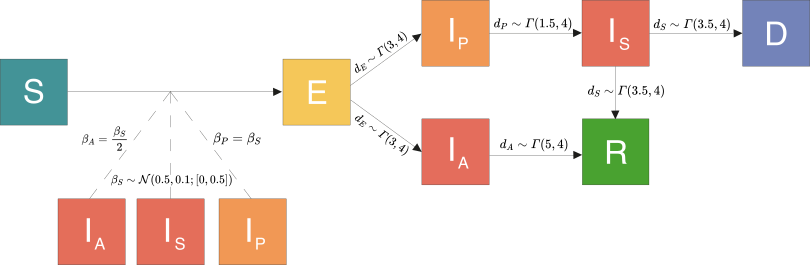

In [72]:
compartmental_diagram = load("/Users/Pit/GitHub/DigitalEpidemiologyProject/Images/CompartmentalDiagram.png")
# COMPARTMENTAL DIAGRAMS FOR DIAGNOSTIC STRATEGIES / SURVEILLANCE MODULE

### Initialization 

In [73]:
# Model initialization 
function InitializeModel(t::Int, provincial_pops::Array{Int,1}, age_provincial_pops::DataFrame,
		home_contact_graph::SimpleWeightedDiGraph{Int64,Float64}, work_contact_graph::SimpleWeightedDiGraph{Int64,Float64}, school_contact_graph::SimpleWeightedDiGraph{Int64,Float64}, other_contact_graph::SimpleWeightedDiGraph{Int64,Float64},
		mobility_graph::SimpleWeightedDiGraph{Int64,Float64},mobility_graph_phase1::SimpleWeightedDiGraph{Int64,Float64},mobility_graph_phase2::SimpleWeightedDiGraph{Int64,Float64},mobility_graph_phase3::SimpleWeightedDiGraph{Int64,Float64},mobility_graph_phase4::SimpleWeightedDiGraph{Int64,Float64},
		h::Real,I0::Int)
	
	# Set populations
	N = sum(Array(age_provincial_pops))  # number of agents
	M = length(provincial_pops)          # number of subpopulations
	K = length(age_provincial_pops[1])   # number of age groups (16)
	# Initialize id 
	id = 0    
	# Initialize Phase 
	phase = 1
	# Define the dictionary of model properties
	properties = @dict(t, phase, 
		home_contact_graph, work_contact_graph, school_contact_graph, other_contact_graph,
		mobility_graph_phase1,mobility_graph_phase2,mobility_graph_phase3,mobility_graph_phase4,
		provincial_pops, age_provincial_pops,
		h, I0,
		N, M, K)

	# Instantiate graph ambient space
	space = GraphSpace(mobility_graph) 
	# Instatiate model
	model = ABM(Patient, space; properties = properties)

	# Populate the model
	for province ∈ 1:M
		for age ∈ 1:K 
			for n ∈ 1:age_provincial_pops[province][age]
				id+=1
				residence=province
				household=[]
                workplace=[]
				pos=residence
				age_group=age
				status=:S
				delay_left=-1
				diagnosis=:O
				add_agent!(pos, model, age_group, residence, household, workplace, status, delay_left, diagnosis)
			end
		end
	end
	
    # Create a list of all agents
    agents = [agent for agent in allagents(model)]
    
	# Initialize households & workplaces
	for agent in agents
		agent.household=InitializeHousehold(agent, model)
		agent.workplace=InitializeWorkplace(agent, model)
	end
	
	# Initialize infected agents 
	for agent in StatsBase.sample(agents, I0)
		agent.status = :E
		agent.delay_left = round(Int, rand(Gamma(3,4)))
	end

	return model
end;

### Simulations 

In [74]:
# Seed Selection
Random.seed!(1234);

# Initialize the model
model = InitializeModel(0,
	provincial_pops, age_provincial_pops, 
	home_contact_graph, work_contact_graph, school_contact_graph, other_contact_graph,
	mobility_graph,mobility_graph_phase1,mobility_graph_phase2,mobility_graph_phase3,mobility_graph_phase4,
	h, I0)

# Surveillance 
susceptible(status) = count(i == :S for i in status)
exposed(status) = count(i == :E for i in status)
infected_presymptomatic(status) = count(i == :I_p for i in status)
infected_symptomatic(status) = count(i == :I_s for i in status)
infected_asymptomatic(status) = count(i == :I_a for i in status)
infected(status) =exposed(status)+infected_asymptomatic(status)+infected_presymptomatic(status)+infected_symptomatic(status)
recovered(status) = count(i == :R for i in status)
dead(status) = count(i == :D for i in status);
###total_tests = nsteps * capacity
###daily_tests = capacity
tested(diagnosis) = count(i != :O for i in diagnosis);
#daily_tested(diagnosis)= count
positive(diagnosis) = count(i == :P for i in diagnosis);
positive_rate(diagnosis)=positive(diagnosis)/tested(diagnosis)
#positive_rate(diagnosis)=positive(diagnosis)/capacity # new_positives/cpacity or #positives/ || "daily tests" != "daily tested people"
infected_rate(status)= infected(status) / model.N

# Data Collection
to_collect = [(:status, susceptible),(:status, exposed),(:status, infected_presymptomatic),(:status, infected_symptomatic),(:status, infected_asymptomatic),(:status, infected),(:status, recovered),(:status, dead),(:status, infected_rate),
	(:diagnosis, tested),(:diagnosis, positive),(:diagnosis, positive_rate)]

data, _ = @time run!(model, agent_step!, model_step!, nsteps; adata = to_collect, replicates=3);

sort!(DataFrame(allagents(model)), :residence, rev = false)

gd = groupby(data, [:step])

147.669662 seconds (603.86 M allocations: 45.405 GiB, 5.74% gc time)


,step,susceptible_status,exposed_status,infected_presymptomatic_status,infected_symptomatic_status
,Int64,Int64,Int64,Int64,Int64
1,0,6212,1,0,0
2,0,6212,1,0,0
3,0,6212,1,0,0
,step,susceptible_status,exposed_status,infected_presymptomatic_status,infected_symptomatic_status
,Int64,Int64,Int64,Int64,Int64
1,100,1100,943,232,577
2,100,753,745,246,682
3,100,968,1035,288,677


## Visualizations

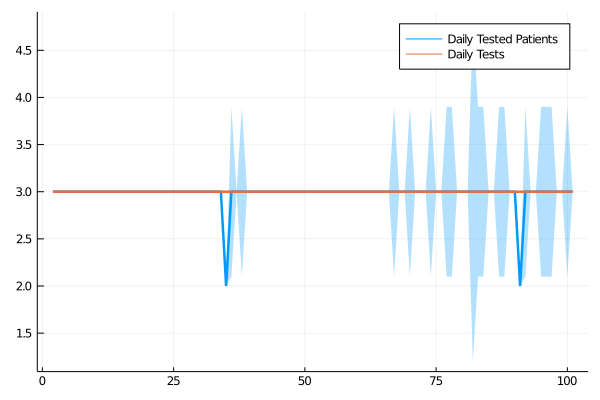

In [75]:
timestep = 2:length(gd)

ft=[quantile(gd[i].tested_diagnosis-gd[i-1].tested_diagnosis,0.05) for i in timestep]
mt=[quantile(gd[i].tested_diagnosis-gd[i-1].tested_diagnosis,0.5) for i in timestep]
nt=[quantile(gd[i].tested_diagnosis-gd[i-1].tested_diagnosis,0.95) for i in timestep]
	
plot(timestep, mt[2:length(mt)],
	label="Tested Patients",
	xlab="Time",
	ylabel="Number",
	#title="DC=$capacity | Χ²=$Χ", 
	legend=:bottomright,
	lw=2.5; 
	ribbon=[mt-ft,nt-mt],
    fillalpha=0.3)
plot(timestep, mt,
	label="Daily Tested Patients",
	lw=2.5;
	ribbon=[mt-ft,nt-mt],
    fillalpha=0.3)
plot!(timestep, [capacity for i in timestep],
      label="Daily Tests",
      lw=2.5)

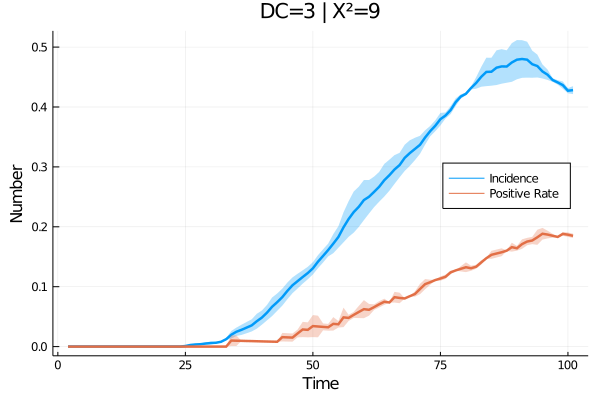

In [76]:
f1=[quantile(gd[i].infected_rate_status,0.05) for i in timestep]
m1=[quantile(gd[i].infected_rate_status,0.5) for i in timestep] 
n1=[quantile(gd[i].infected_rate_status,0.95) for i in timestep]

f2=[quantile(gd[i].positive_rate_diagnosis,0.05) for i in timestep]
m2=[quantile(gd[i].positive_rate_diagnosis,0.5) for i in timestep] 
n2=[quantile(gd[i].positive_rate_diagnosis,0.95) for i in timestep]

Χ = round(Int, sum(((m2-m1).^2)./m1))

plot(timestep, m1,
	label="Incidence",
	xlab="Time",
	ylabel="Number",
	title="DC=$capacity | Χ²=$Χ", 
	legend=:right,
	lw=2.5; 
	ribbon=[m1-f1,n1-m1],
    fillalpha=0.3)
plot!(timestep, m2,
	label="Positive Rate",
	lw=2.5; 
	ribbon=[m2-f2,n2-m2],
    fillalpha=0.3)

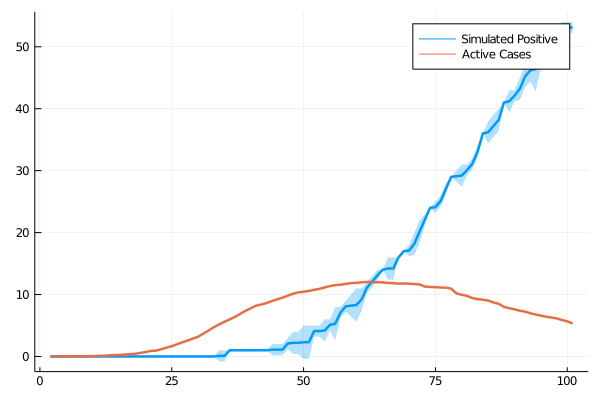

In [77]:
m=[quantile(gd[i].infected_status,0.05) for i in 2:length(gd)]
f=[quantile(gd[i].infected_status,0.5) for i in 2:length(gd)] 
n=[quantile(gd[i].infected_status,0.95) for i in 2:length(gd)]


m0=[quantile(gd[i].positive_diagnosis,0.05) for i in 2:length(gd)]
f0=[quantile(gd[i].positive_diagnosis,0.5) for i in 2:length(gd)] 
n0=[quantile(gd[i].positive_diagnosis,0.95) for i in 2:length(gd)]

#=plot(timestep, m,
	label="Simulated Infected",
	xlab="Time",
	ylabel="Number",
	#title="DC=$capacity | Χ²=$Χ", 
	legend=:right,
	lw=2.5;
	ribbon=[m-f,n-m],
    fillalpha=0.3)=#
plot(timestep, m0,
	  label="Simulated Positive",
	  lw=2.5; 
	  ribbon=[m0-f0,n0-m0],
      fillalpha=0.3)
plot!(timestep,active_cases["Active Cases"][1:100]/scale_factor,
	  label="Active Cases",
	  lw=2.5)

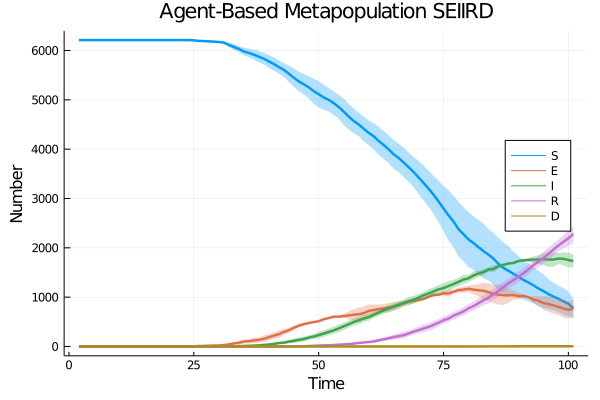

In [78]:
# Ensemble of susceptibles
m3=[quantile(gd[i].susceptible_status,0.05) for i in 2:length(gd)]
f3=[quantile(gd[i].susceptible_status,0.5) for i in 2:length(gd)] 
n3=[quantile(gd[i].susceptible_status,0.95) for i in 2:length(gd)]
# Ensemble of exposed
m4=[quantile(gd[i].exposed_status,0.05) for i in 2:length(gd)]
f4=[quantile(gd[i].exposed_status,0.5) for i in 2:length(gd)] 
n4=[quantile(gd[i].exposed_status,0.95) for i in 2:length(gd)]
# Ensemble of infected
m5=[quantile(gd[i].infected_presymptomatic_status+gd[i].infected_symptomatic_status+gd[i].infected_asymptomatic_status,0.05) for i in 2:length(gd)]
f5=[quantile(gd[i].infected_presymptomatic_status+gd[i].infected_symptomatic_status+gd[i].infected_asymptomatic_status,0.5) for i in 2:length(gd)] 
n5=[quantile(gd[i].infected_presymptomatic_status+gd[i].infected_symptomatic_status+gd[i].infected_asymptomatic_status,0.95) for i in 2:length(gd)]
# Ensemble of recovered
m6=[quantile(gd[i].recovered_status,0.05) for i in 2:length(gd)]
f6=[quantile(gd[i].recovered_status,0.5) for i in 2:length(gd)] 
n6=[quantile(gd[i].recovered_status,0.95) for i in 2:length(gd)]
# Ensemble of died
m7=[quantile(gd[i].dead_status,0.05) for i in 2:length(gd)]
f7=[quantile(gd[i].dead_status,0.5) for i in 2:length(gd)] 
n7=[quantile(gd[i].dead_status,0.95) for i in 2:length(gd)]

# Plot
plot(timestep, m3,
	label="S",
	xlab="Time",
	ylabel="Number",
	title="Agent-Based Metapopulation SEIIRD", 
	legend=:right,
	lw=2.5; 
	ribbon=[m3-f3,n3-m3],
    fillalpha=0.3)
plot!(timestep, m4,label="E",lw=2.5; ribbon=[m4-f4,n4-m4],fillalpha=0.3)
plot!(timestep, m5,label="I",lw=2.5; ribbon=[m5-f5,n5-m5],fillalpha=0.3)
plot!(timestep, m6,label="R",lw=2.5; ribbon=[m6-f6,n6-m6],fillalpha=0.3)
plot!(timestep, m7,label="D",lw=2.5; ribbon=[m7-f7,n7-m7],fillalpha=0.3)

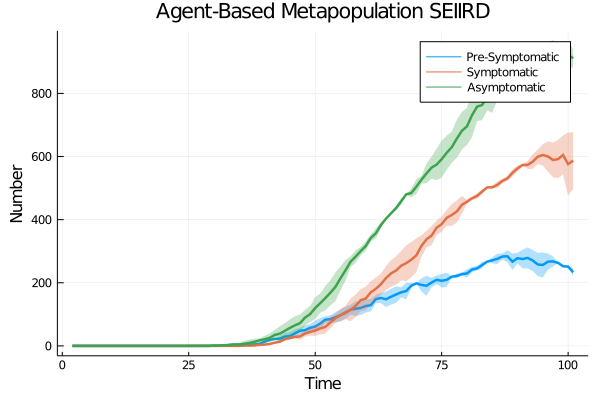

In [79]:
m8=[quantile(gd[i].infected_presymptomatic_status,0.05) for i in 2:length(gd)]
f8=[quantile(gd[i].infected_presymptomatic_status,0.5) for i in 2:length(gd)] 
n8=[quantile(gd[i].infected_presymptomatic_status,0.95) for i in 2:length(gd)]

m9=[quantile(gd[i].infected_symptomatic_status,0.05) for i in 2:length(gd)]
f9=[quantile(gd[i].infected_symptomatic_status,0.5) for i in 2:length(gd)] 
n9=[quantile(gd[i].infected_symptomatic_status,0.95) for i in 2:length(gd)]

m10=[quantile(gd[i].infected_asymptomatic_status,0.05) for i in 2:length(gd)]
f10=[quantile(gd[i].infected_asymptomatic_status,0.5) for i in 2:length(gd)] 
n10=[quantile(gd[i].infected_asymptomatic_status,0.95) for i in 2:length(gd)]

plot(timestep, m8,
	label="Pre-Symptomatic",
	xlab="Time",
	ylabel="Number",
	title="Agent-Based Metapopulation SEIIRD", 
	legend=:topright,
	lw=2.5; 
	ribbon=[m8-f8,n8-m8],
    fillalpha=0.3)
plot!(timestep, m9,label="Symptomatic",lw=2.5; ribbon=[m9-f9,n9-m9],fillalpha=0.3)
plot!(timestep, m10,label="Asymptomatic",lw=2.5; ribbon=[m10-f10,n10-m10],fillalpha=0.3)

## References

### Data

#### Geospatial
* ISTAT, [Confini delle unità amministrative a fini statistici al 1° Gennaio 2020](https://www.istat.it/it/archivio/222527). (2020)
* OpenPolis. [Limits of Italian Provinces](https://github.com/openpolis/geojson-italy/blob/master/geojson/limits_IT_provinces.geojson). *GitHub* (2019)

#### Population
* ISTAT, [Resident Population by Sex, Age and Marital Status](http://demo.istat.it/pop2020/index_e.html) (2020).
* ISTAT, [Population census data](http://dati.istat.it/Index.aspx?QueryId=18460) (2020).

#### Social
* Mossong J, Hens N, Jit M, Beutels P, Auranen K, Mikolajczyk R, et al. (2008) [Social Contacts and Mixing Patterns Relevant to the Spread of Infectious Diseases](https://doi.org/10.1371/journal.pmed.0050074). *PLoS Med* 5(3): e74. 
* Prem K, Cook AR, Jit M (2017). [Projecting social contact matrices in 152 countries using contact surveys and demographic data](https://doi.org/10.1371/journal.pcbi.1005697). *PLoS Comput Biol* 13(9).
* Kiesha Prem et al. (2020). [Projecting contact matrices in 177 geographical regions: an update and comparison with empirical data for the COVID-19 era](https://doi.org/10.1101/2020.07.22.20159772). *medRxiv pre-print*. 

#### Mobility 
* Pepe, E., Bajardi, P., Gauvin, L. et al. [COVID-19 outbreak response, a dataset to assess mobility changes in Italy following national lockdown](https://doi.org/10.1038/s41597-020-00575-2). *Scientific Data* 7, 230 (2020).

#### Diagnostic
* ECDC, [Diagnostic testing and screening for SARS-CoV-2](https://www.ecdc.europa.eu/en/covid-19/latest-evidence/diagnostic-testing), 2020
* ECDC, [Testing strategies](https://www.ecdc.europa.eu/en/covid-19/surveillance/testing-strategies), 2020
* European Commission (EC). [Current performance of COVID-19 test methods and devices and proposed performance criteria](https://ec.europa.eu/docsroom/documents/40805) (16 April 2020). Brussels: EC; [21 April, 2020]. 
* Jessica Watson et al. [Interpreting a covid-19 test result](https://doi.org/10.1136/bmj.m1808). *BMJ*, 2020.
* Edward C.Stites, Craig B.Wilen. [The Interpretation of SARS-CoV-2 Diagnostic Tests](https://doi.org/10.1016/j.medj.2020.08.001), *Med* (2020).
* Sethuraman N, Jeremiah SS, Ryo A. [Interpreting Diagnostic Tests for SARS-CoV-2](https://doi.org/10.1001/jama.2020.8259). *JAMA*. 2020;323(22):2249–2251.
* Diagnostics Committee of the Infectious Diseases Society of America (IDSA), [Molecular Testing for Acute Respiratory Tract Infections: Clinical and Diagnostic Recommendations From the IDSA’s Diagnostics Committee](https://doi.org/10.1093/cid/ciaa508), *Clinical Infectious Diseases*, , ciaa508
* [False Negative Tests for SARS-CoV-2 Infection — Challenges and Implications](https://doi.org/10.1056/NEJMp2015897) *N Engl J Med* 2020; 383:e38
* [Saliva or Nasopharyngeal Swab Specimens for Detection of SARS-CoV-2](https://doi.org/10.1056/NEJMc2016359) 
* Lisboa Bastos Mayara, Tavaziva Gamuchirai, Abidi Syed Kunal, Campbell Jonathon R, Haraoui Louis-Patrick, Johnston James C et al. [Diagnostic accuracy of serological tests for covid-19: systematic review and meta-analysis](https://doi.org/10.1136/bmj.m2516) *BMJ* 2020; 370 :m2516
* Kucirka, Lauren M., et al. [Variation in false-negative rate of reverse transcriptase polymerase chain reaction–based SARS-CoV-2 tests by time since exposure](https://doi.org/10.7326/M20-1495). *Annals of Internal Medicine* (2020).

#### Epidemiological
* Our World in Data, [Data on COVID-19](https://github.com/owid/covid-19-data/tree/master/public/data).
* COVID-19 Routes, [Data Fetching for Italy](https://github.com/COVID-19-routes/data-model).
* PCM-DPC, [COVID-19 Data for Italy](https://github.com/pcm-dpc/COVID-19).
* Davies, N.G., Klepac, P., Liu, Y. et al. [Age-dependent effects in the transmission and control of COVID-19 epidemics](https://doi.org/10.1038/s41591-020-0962-9). *Nature Medicine* 26, 1205–1211 (2020). 
* Kiesha Prem et al. (2020). [Projecting contact matrices in 177 geographical regions: an update and comparison with empirical data for the COVID-19 era](https://doi.org/10.1101/2020.07.22.20159772). *medRxiv pre-print*. 
* Oxford University Clinical Research Unit COVID-19 Research Group, [The Natural History and Transmission Potential of Asymptomatic Severe Acute Respiratory Syndrome Coronavirus 2 Infection](https://doi.org/10.1093/cid/ciaa711), *Clinical Infectious Diseases*, ciaa711
* Poletti Piero wt al. [Age-specific SARS-CoV-2 infection fatality ratio and associated risk factors, Italy, February to April 2020](https://doi.org/10.2807/1560-7917.ES.2020.25.31.2001383). *Euro Surveill.* 2020;25(31):pii=2001383. 

#### Policy 
* Desvars-Larrive, A., Dervic, E., Haug, N. et al. [A structured open dataset of government interventions in response to COVID-19](https://doi.org/10.1038/s41597-020-00609-9). *Scientific Data* 7, 285 (2020).

### Modelling

#### Conceptual
* Vespignani, A., Tian, H., Dye, C. et al. [Modelling COVID-19](https://doi.org/10.1038/s42254-020-0178-4). Nat Rev Phys 2, 279–281 (2020)

* Metcalf et al. [Mathematical models to guide pandemic response](https://doi.org/10.1126/science.abd1668). *Science Perspective* (2020).
* Ernesto Estrada. [COVID-19 and SARS-CoV-2. Modeling the present, looking at the future](https://doi.org/10.1016/j.physrep.2020.07.005). *Physics Reports* (2020).
* Bjørnstad, O.N., Shea, K., Krzywinski, M. et al. [The SEIRS model for infectious disease dynamics](https://doi.org/10.1038/s41592-020-0856-2). *Nature Methods* 17, 557–558 (2020). 

#### Metapopulation
* Alun Lloyd, Vincent Jansenc. [Spatiotemporal dynamics of epidemics: synchrony in metapopulation models](https://doi.org/10.1016/j.mbs.2003.09.003). *Mathematical Biosciences* (2004).
* Duncan J. Watts et al. [Multiscale, resurgent epidemics in a hierarchical metapopulation model](https://doi.org/10.1073/pnas.0501226102). *PNAS* (2005)
* Vittoria Colizza, Alessandro Vespignani. [Epidemic modeling in metapopulation systems with heterogeneous coupling pattern: Theory and simulations](https://doi.org/10.1016/j.jtbi.2007.11.028). *Journal of Theoretical Biology* (2008).
* Balcan, Duygu, Vittoria Colizza, Bruno Gonçalves, Hao Hu, José J. Ramasco, and Alessandro Vespignani. [Multiscale mobility networks and the spatial spreading of infectious diseases](https://doi.org/10.1073/pnas.0906910106). *Proceedings of the National Academy of Sciences* 106, no. 51 (2009): 21484-21489.
* Balcan, Duygu, Bruno Gonçalves, Hao Hu, José J. Ramasco, Vittoria Colizza, and Alessandro Vespignani. [Modeling the spatial spread of infectious diseases: The GLobal Epidemic and Mobility computational model](https://doi.org/10.1016/j.jocs.2010.07.002). *Journal of Computational Science* 1, no. 3 (2010): 132-145
* Ross JV, House T, Keeling MJ [Calculation of Disease Dynamics in a Population of Households](https://doi.org/10.1371/journal.pone.0009666). *PLoS ONE* (2010)
* Salathé M, Jones JH (2010) [Dynamics and Control of Diseases in Networks with Community Structure](https://doi.org/10.1371/journal.pcbi.1000736). *PLoS Comput Biol* 6(4): e1000736
* Apolloni, A., Poletto, C., Ramasco, J.J. et al. [Metapopulation epidemic models with heterogeneous mixing and travel behaviour](https://doi.org/10.1186/1742-4682-11-3). *Theor Biol Med Model* 11, 3 (2014)
* Daniela Calvetti et al. [Metapopulation Network Models for Understanding, Predicting, and Managing the Coronavirus Disease COVID-19](https://doi.org/10.3389/fphy.2020.00261). *Front. Phys.*, 2020
* Hassan S, Mughal BJ, Siwiak M, Yasin Z. [A modified SEIR meta-population transmission based Modeling and Forecasting of the COVID-19 pandemic in Pakistan](https://doi.org/10.1101/2020.06.03.20121517). *medRxiv*, 2020
* Stephen J Beckett et al. [Spread of COVID-19 through Georgia, USA. Near-term projections and impacts of social distancing via a metapopulation model](https://doi.org/10.1101/2020.05.28.20115642). *medRxiv pre-print* (2020)

#### Calibration
* Hazelbag CM, Dushoff J, Dominic EM, Mthombothi ZE, Delva W (2020) [Calibration of individual-based models to epidemiological data: A systematic review](https://doi.org/10.1371/journal.pcbi.1007893). *PLoS Comput Biol* 16(5): e1007893

##### Surveillance 
* Daniel B Larremore et al. [Test sensitivity is secondary to frequency and turnaround time for COVID-19 surveillance](https://doi.org/10.1101/2020.06.22.20136309), *medRxiv* (2020)
* Yang Liu et al. [A Modelling Study for Designing a Multi-layered Surveillance Approach to Detect the Potential Resurgence of SARS-CoV-2](https://doi.org/10.1101/2020.06.27.20141440), *medRxiv* (2020)
* Frank G Sandmann, Peter J White, Mary Ramsay, Mark Jit, [Optimizing Benefits of Testing Key Workers for Infection with SARS-CoV-2: A Mathematical Modeling Analysis](https://doi.org/10.1093/cid/ciaa901), *Clinical Infectious Diseases*,  ciaa901

##### Interventions
* Josh A Firth, Joel Hellewell, Petra Klepac, Stephen M Kissler et al. [Combining fine-scale social contact data with epidemic modelling reveals interactions between contact tracing, quarantine, testing and physical distancing for controlling COVID-19](https://cmmid.github.io/topics/covid19/tracing-network-local.html), *CMMID pre-print* (2020)
*  Akira Endo et al. [Implication of backward contact tracing in the presence of overdispersed transmission in COVID-19 outbreaks](https://cmmid.github.io/topics/covid19/backwardtracing.html), *CMMID pre-print* (2020)
* Giordano, G., Blanchini, F., Bruno, R. et al. [Modelling the COVID-19 epidemic and implementation of population-wide interventions in Italy](https://doi.org/10.1038/s41591-020-0883-7). Nat Med 26, 855–860 (2020) 
* Marino Gatto et al. [Spread and dynamics of the COVID-19 epidemic in Italy: Effects of emergency containment measures](https://doi.org/10.1073/pnas.2004978117). *PNAS* (2020)
* Bertuzzo, E., Mari, L., Pasetto, D. et al. [The geography of COVID-19 spread in Italy and implications for the relaxation of confinement measures](https://doi.org/10.1038/s41467-020-18050-2). Nat Commun 11, 4264 (2020)
* Aleta, A., Martín-Corral, D., Pastore y Piontti, A. et al. [Modelling the impact of testing, contact tracing and household quarantine on second waves of COVID-19]( https://doi.org/10.1038/s41562-020-0931-9). Nat Hum Behav (2020)

##### Mortality 
* WHO, [Estimating mortality from COVID-19](https://www.who.int/news-room/commentaries/detail/estimating-mortality-from-covid-19), *Scientific Brief* (2020)